#DATASCI W261: Machine Learning at Scale

#HW7 (Group Z)

- **Juanjo Carin, Christopher Llop, Sayantan Satpati**
- [juanjose.carin@ischool.berkeley.edu](mailto:juanjose.carin@ischol.berkeley.com)
- [christopher.llop@ischool.berkeley.edu](mailto:christopher.llop@ischool.berkeley.edu)
- [sayantan.satpati@ischool.berkeley.edu](mailto:sayantan.satpati@ischool.berkeley.edu)
- W261-2
- Week 07
- Submission date: 10/27/2015

#General Description

**In this assignment you will explore networks and develop MRJob code for finding shortest path graph distances. To build up to large data you will develop your code on some very simple, toy networks. After this you will take your developed code forward and modify it and apply it to two larger datasets (performing EDA along the way).**

#Undirected toy network dataset

**In an undirected network all links are symmetric, i.e., for a pair of nodes 'A' and 'B,' both of the links A -> B and B -> A will exist.**

**The toy data are available in a sparse (stripes) representation:**

    (node) \t (dictionary of links)

**on AWS via the url: s3://ucb-mids-mls-networks/undirected_toy.txt**

**In the dictionary, target nodes are keys, link weights are values (here, all weights are 1, i.e., the network is unweighted).**

#Directed toy network dataset

**In a directed network all links are not necessarily symmetric, i.e., for a pair of nodes 'A' and 'B,' it is possible for only one of A -> B or B -> A to exist.**

**These toy data are available in a sparse (stripes) representation:**

    (node) \t (dictionary of links)

**on AWS via the url: s3://ucb-mids-mls-networks/directed_toy.txt**

**In the dictionary, target nodes are keys, link weights are values (here, all weights are 1, i.e., the network is unweighted).**

#HW7.0: Shortest path graph distances (toy networks)

**In this part of your assignment you will develop the base of your code for the week.**

**Write MRJob classes to find shortest path graph distances, as described in the lectures. In addition to finding the distances, your code should also output a distance-minimizing path between the source and target. Work locally for this part of the assignment, and use both of the undirected and directed toy networks.**

**To proof you code's function, run the following jobs**

- **shortest path in the undirected network from node 1 to node 4**
    - **Solution: 1,5,4**
- **shortest path in the directed network from node 1 to node 5**
    - **Solution: 1,2,4,5**

**and report your output---make sure it is correct!**

## Importing Libraries and Downloading Data

In [1]:
# Turn on autoreload for easier troubleshooting.
# This function causes iPython to re-load modules before executing code, which
    # is useful because we will be updating the MRJob code while troubleshooting
%load_ext autoreload
%autoreload 2

import networkx as nx
import ast
import matplotlib.pyplot as plt
%matplotlib inline

GLOBAL_PATH = "/HD/Dropbox2/Dropbox/W261/HW7/"

In [2]:
# Get data from S3 for local exploration
!aws s3 sync s3://ucb-mids-mls-networks/ $GLOBAL_PATH

download: s3://ucb-mids-mls-networks/PageRank-test.txt to ../../../../../../../HD/Dropbox2/Dropbox/W261/HW7/PageRank-test.txt
download: s3://ucb-mids-mls-networks/randNet.txt to ../../../../../../../HD/Dropbox2/Dropbox/W261/HW7/randNet.txt
download: s3://ucb-mids-mls-networks/randNet_topics.txt to ../../../../../../../HD/Dropbox2/Dropbox/W261/HW7/randNet_topics.txt


##Graph representation

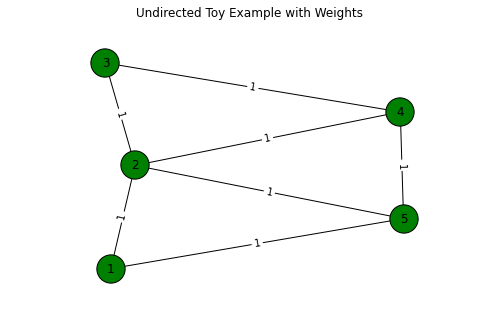

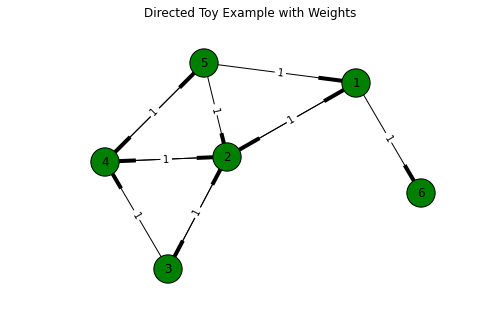

In [3]:
# Flexible Load Data Function
def load_data(filename):
    nodes = set()
    edges = set()
    with open (filename, 'r') as myfile:
        for line in myfile:
            line = line.split('\t')
            node = line[0]
            if node not in nodes:
                nodes.add(node)
            node_neighbors = ast.literal_eval(line[1])
            for k in node_neighbors.keys():
                edges.add((node, k, node_neighbors[k]))
                if k not in nodes:
                    nodes.add(k)
    return nodes, edges

# Plot Undirected Graph
G=nx.Graph()
nodes, edges = load_data('./undirected_toy.txt')

# Load into networkx
for node in nodes:
    G.add_node(node)    
for edge in edges:
    G.add_edge(edge[0], edge[1], weight=edge[2])

# Plot network 
pos=nx.spring_layout(G)
nx.draw(G,pos, with_labels = True, node_color='g', node_size = 800)
# Specifiy Edge Labels
edge_labels=dict([((u,v,),d['weight']) for u,v,d in G.edges(data=True)])
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
plt.title("Undirected Toy Example with Weights")
plt.show()

# Plot Directed Graph
G=nx.DiGraph()
nodes, edges = load_data('./directed_toy.txt')

# Load into networkx
for node in nodes:
    G.add_node(node)    
for edge in edges:
    G.add_edge(edge[0], edge[1], weight=edge[2])

# Plot network 
pos=nx.spring_layout(G)
nx.draw(G,pos, with_labels = True, node_color='g', node_size = 800)
# Specifiy Edge Labels
edge_labels=dict([((u,v,),d['weight']) for u,v,d in G.edges(data=True)])
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
plt.title("Directed Toy Example with Weights")
plt.show()

We tried several approaches, each one an optimized version of the previous.

It is IMPORTANT to note that, in order to work with all kinds of graphs, our implementation is based on weighted graphs (last part of the asynchronous material covered in this week's lecture), and hence can work with weighted & unweighted graphs (as well as directed & undirected).

#1st version

Our first attempt is based on the pseudo mentioned in **7.14**. There are 2 files (that replicate a dictionary and a list in Python, respectively) that store the minimum distance and corresponding path for each node and the nodes in the frontier. Both files need to be updated in subsequent iterations, and they are re-written inside the MRJob (that is changed in the 2nd & later versions).

##MRJob code

In [4]:
%%writefile ShortestPath.py
#!/home/hduser/anaconda/bin/python
from numpy import argmin, array, random
from mrjob.job import MRJob
from mrjob.job import MRStep
import ast

GLOBAL_PATH = "/HD/Dropbox2/Dropbox/W261/HW7/"

class ShortestPath(MRJob):
    Frontiers = []
    SSSP = {}
    
    def steps(self):
        return [
            MRStep(mapper_init = self.mapper_init, mapper=self.mapper,
                   reducer_init = self.reducer_init, reducer = self.reducer)
        ]

    ## Load Frontiers & SSSP info into Mappers
    def mapper_init(self):
        ## Frontiers is a list of the nodes currenly in the Frontier
        self.Frontiers = [s.strip() for s in 
                          open(GLOBAL_PATH + 'Frontiers.txt').readlines()]
        #open(GLOBAL_PATH + 'Frontiers.txt', 'w').close()
        ## SSSP is a dict with the shortest distance and corresponding path for 
            ## each node
        with open(GLOBAL_PATH + 'SSSP.txt', 'r') as f:
            for line in f:
                line = line.strip().split('\t')
                dist_path = line[1].split(',')
                self.SSSP[line[0]] = [float(dist_path[0]), dist_path[1]]
        
    ## Load data and output distance & path for nodes connected to those in the
        ## Frontier
    def mapper(self, _, line):
        ## PSEUDOCODE
        ## for each node v in G
            ## for each node u outgouing from v
                ## if v in Frontiers
                    ## Output: (u, SSSP[v] + Dist(v,u))
        line = line.split('\t')
        node = line[0]
        sink = ast.literal_eval(line[1])
        if node in self.Frontiers:
            for sink_node in sink.keys():
                if len(self.SSSP[node][1]) !=0 :
                    yield sink_node, [self.SSSP[node][0] + sink[sink_node], 
                                      self.SSSP[node][1] + '/']
                else:
                    yield sink_node, [self.SSSP[node][0] + sink[sink_node], 
                                      self.SSSP[node][1] + node + '/']
                
    def reducer_init(self):
        ## PSEUDOCODE
        ## Frontiers = []
        self.Frontiers = []
        with open(GLOBAL_PATH + 'SSSP.txt', 'r') as f:
            for line in f:
                line = line.strip().split('\t')
                dist_path = line[1].split(',')
                self.SSSP[line[0]] = [float(dist_path[0]), dist_path[1]]

    def reducer(self, node, values):
        ## PSEUDOCODE
        ## for each key k find the minimum value Dmin[k]
        ## if Dmin[k] < SSSP[k]
            ## SSSP[k] = Dmin[k]
            ## Push k in Frontiers
            ## Output (k, SSSP[k])
        dist_path = [v for v in values]
        distances = [int(d[0]) for d in dist_path]
        min_distance = min(distances)
        path_min_distance = [d[1] for d in dist_path if d[0]==min_distance][0]
        if min_distance < self.SSSP[node][0]:
            self.SSSP[node][0] = float(min_distance)
            self.SSSP[node][1] = path_min_distance + node
            with open(GLOBAL_PATH + 'SSSP.txt', 'w+') as f:
                for k in self.SSSP.keys():
                    f.writelines(k + '\t' + ','.join([str(x) for x in 
                                                      self.SSSP[k]]) + '\n')
            self.Frontiers.append(node)
            with open(GLOBAL_PATH + 'Frontiers.txt', 'w+') as f:
                for node in self.Frontiers:
                    f.writelines(node + '\n')
            yield None, node
        
if __name__ == '__main__':
    ShortestPath.run()

Overwriting ShortestPath.py


In [5]:
!chmod +x ShortestPath.py

##Driver and solution for the 2 toy examples

In [6]:
from ShortestPath import ShortestPath

files = ['undirected_toy.txt', 'directed_toy.txt']

for current_file in files:
    mr_job = ShortestPath(args=[GLOBAL_PATH + current_file])
    ## Initialization
        ## Get nodes
    nodes = set()
    with open(GLOBAL_PATH + current_file, 'r') as myfile:
        for line in myfile:
            line = line.split('\t')
            node = line[0]
            if node not in nodes:
                nodes.add(node)
            node_neighbors = ast.literal_eval(line[1])
            for k in node_neighbors.keys():
                if k not in nodes:
                    nodes.add(k)
    nodes = list(nodes)
        ## Define source
    source = '1'
        ## Initialize SSSP
    SSSP = {}
    for node in nodes:
        if node == source:
            SSSP[node] = [0, ""]
        else:
            SSSP[node] = [float('inf'), ""]
    with open(GLOBAL_PATH + 'SSSP.txt', 'w+') as f:
        for node in SSSP.keys():
            f.writelines(node + '\t' + ','.join([str(x) for x in SSSP[node]]) 
                         + '\n')
        ## Initialize Frontier
    Frontiers = [source]
    with open(GLOBAL_PATH + 'Frontiers.txt', 'w+') as f:
        for node in Frontiers:
            f.writelines(node + '\n')
    
    print '==== ', current_file, ' ===='
    
    # Update shortest paths iteratively
    i=0
    while len(Frontiers) != 0:
        Frontiers = []
        print "\nIteration "+str(i+1)+":"
        with mr_job.make_runner() as runner: 
            runner.run()
            # stream_output: get access of the output 
            for line in runner.stream_output():
                key,value =  mr_job.parse_output_line(line)
                Frontiers.append(value)
        print 'Frontiers', Frontiers
        SSSSP = {}
        with open(GLOBAL_PATH + 'SSSP.txt', 'r') as f:
            for line in f:
                    line = line.strip().split('\t')
                    dist_path = line[1].split(',')
                    SSSP[line[0]] = [float(dist_path[0]), dist_path[1]]
            print SSSP
        i = i + 1
    if current_file == 'undirected_toy.txt':
        print '\nShortest path in the undirected network from node 1 to node '\
            '4: {} (Distance: {})'.format(SSSP['4'][1], int(SSSP['4'][0]))
        print '\n============================\n'
    else:
        print '\nShortest path in the directed network from node 1 to node '\
            '5: {} (Distance: {})'.format(SSSP['5'][1], int(SSSP['5'][0]))

====  undirected_toy.txt  ====

Iteration 1:
Frontiers ['2', '5']
{'1': [0.0, ''], '3': [inf, ''], '2': [1.0, '1/2'], '5': [1.0, '1/5'], '4': [inf, '']}

Iteration 2:
Frontiers ['3', '4']
{'1': [0.0, ''], '3': [2.0, '1/2/3'], '2': [1.0, '1/2'], '5': [1.0, '1/5'], '4': [2.0, '1/2/4']}

Iteration 3:
Frontiers []
{'1': [0.0, ''], '3': [2.0, '1/2/3'], '2': [1.0, '1/2'], '5': [1.0, '1/5'], '4': [2.0, '1/2/4']}

Shortest path in the undirected network from node 1 to node 4: 1/2/4 (Distance: 2)


====  directed_toy.txt  ====

Iteration 1:
Frontiers ['2', '6']
{'1': [0.0, ''], '3': [inf, ''], '2': [1.0, '1/2'], '5': [inf, ''], '4': [inf, ''], '6': [1.0, '1/6']}

Iteration 2:
Frontiers ['3', '4']
{'1': [0.0, ''], '3': [2.0, '1/2/3'], '2': [1.0, '1/2'], '5': [inf, ''], '4': [2.0, '1/2/4'], '6': [1.0, '1/6']}

Iteration 3:
Frontiers ['5']
{'1': [0.0, ''], '3': [2.0, '1/2/3'], '2': [1.0, '1/2'], '5': [3.0, '1/2/4/5'], '4': [2.0, '1/2/4'], '6': [1.0, '1/6']}

Iteration 4:
Frontiers []
{'1': [0.0, '

There are more than 1 possible solution (i.e., different paths whose total length is minimum).

#2nd version

In this 2nd version the SSSP and Frontiers files are re-written in the Drive, not in the MapReduce job.

##MRJob code

In [7]:
%%writefile ShortestPath.py
#!/home/hduser/anaconda/bin/python
from numpy import argmin, array, random
from mrjob.job import MRJob
from mrjob.job import MRStep
import ast

GLOBAL_PATH = "/HD/Dropbox2/Dropbox/W261/HW7/"

class ShortestPath(MRJob):
    Frontiers = []
    SSSP = {}
    
    def steps(self):
        return [
            MRStep(mapper_init = self.mapper_init, mapper=self.mapper,
                   reducer_init = self.reducer_init, reducer = self.reducer)
        ]

    ## Load Frontiers & SSSP info into Mappers
    def mapper_init(self):
        ## Frontiers is a list of the nodes currenly in the Frontier
        self.Frontiers = [s.strip() for s in 
                          open(GLOBAL_PATH + 'Frontiers.txt').readlines()]
        open(GLOBAL_PATH + 'Frontiers.txt', 'w').close()
        ## SSSP is a dict with the shortest distance and corresponding path for 
            ## each node
        with open(GLOBAL_PATH + 'SSSP.txt', 'r') as f:
            for line in f:
                line = line.strip().split('\t')
                dist_path = line[1].split(',')
                self.SSSP[line[0]] = [float(dist_path[0]), dist_path[1]]
        
    ## Load data and output distance & path for nodes connected to those in the
        ## Frontier
    def mapper(self, _, line):
        ## PSEUDOCODE
        ## for each node v in G
            ## for each node u outgouing from v
                ## if v in Frontiers
                    ## Output: (u, SSSP[v] + Dist(v,u))
        line = line.split('\t')
        node = line[0]
        sink = ast.literal_eval(line[1])
        if node in self.Frontiers:
            for sink_node in sink.keys():
                if len(self.SSSP[node][1]) !=0 :
                    yield sink_node, [self.SSSP[node][0] + sink[sink_node], 
                                      self.SSSP[node][1] + '/']
                else:
                    yield sink_node, [self.SSSP[node][0] + sink[sink_node], 
                                      self.SSSP[node][1] + node + '/']
                
    def reducer_init(self):
        ## PSEUDOCODE
        ## Frontiers = []
        with open(GLOBAL_PATH + 'SSSP.txt', 'r') as f:
            for line in f:
                line = line.strip().split('\t')
                dist_path = line[1].split(',')
                self.SSSP[line[0]] = [float(dist_path[0]), dist_path[1]]

    def reducer(self, node, values):
        ## PSEUDOCODE
        ## for each key k find the minimum value Dmin[k]
        ## if Dmin[k] < SSSP[k]
            ## SSSP[k] = Dmin[k]
            ## Push k in Frontiers
            ## Output (k, SSSP[k])
        dist_path = [v for v in values]
        distances = [int(d[0]) for d in dist_path]
        min_distance = min(distances)
        path_min_distance = [d[1] for d in dist_path if d[0]==min_distance][0]
        if min_distance < self.SSSP[node][0]:
            self.SSSP[node][0] = float(min_distance)
            self.SSSP[node][1] = path_min_distance + node
            yield node, self.SSSP[node]
        
if __name__ == '__main__':
    ShortestPath.run()

Overwriting ShortestPath.py


In [8]:
!chmod +x ShortestPath.py

##Driver and solution for the 2 toy examples

In [9]:
from ShortestPath import ShortestPath

files = ['undirected_toy.txt', 'directed_toy.txt']

for current_file in files:
    mr_job = ShortestPath(args=[GLOBAL_PATH + current_file])
    ## Initialization
        ## Get nodes
    nodes = set()
    with open(GLOBAL_PATH + current_file, 'r') as myfile:
        for line in myfile:
            line = line.split('\t')
            node = line[0]
            if node not in nodes:
                nodes.add(node)
            node_neighbors = ast.literal_eval(line[1])
            for k in node_neighbors.keys():
                if k not in nodes:
                    nodes.add(k)
    nodes = list(nodes)
        ## Define source
    source = '1'
        ## Initialize SSSP
    SSSP = {}
    for node in nodes:
        if node == source:
            SSSP[node] = [0, ""]
        else:
            SSSP[node] = [float('inf'), ""]
    with open(GLOBAL_PATH + 'SSSP.txt', 'w+') as f:
        for node in SSSP.keys():
            f.writelines(node + '\t' + ','.join([str(x) for x in SSSP[node]]) 
                         + '\n')

    ## Initialize Frontier
    Frontiers = [source]
    with open(GLOBAL_PATH + 'Frontiers.txt', 'w+') as f:
        for node in Frontiers:
            f.writelines(node + '\n')
    
    print '==== ', current_file, ' ===='
    
    # Update shortest paths iteratively
    i=0
    while len(Frontiers) != 0:
        Frontiers = []
        SSSP = {}
        with open(GLOBAL_PATH + 'SSSP.txt', 'r') as f:
            for line in f:
                    line = line.strip().split('\t')
                    dist_path = line[1].split(',')
                    SSSP[line[0]] = [float(dist_path[0]), dist_path[1]]
        print "\nIteration "+str(i+1)+":"
        with mr_job.make_runner() as runner: 
            runner.run()
            # stream_output: get access of the output 
            for line in runner.stream_output():
                key,value =  mr_job.parse_output_line(line)
                Frontiers.append(key)
                SSSP[key] = value
            with open(GLOBAL_PATH + 'SSSP.txt', 'w+') as f:
                for node in SSSP.keys():
                    f.writelines(node + '\t' + ','.join([str(x) for x in SSSP[node]]) + '\n')
            print SSSP
        print 'Frontiers', Frontiers
        with open(GLOBAL_PATH + 'Frontiers.txt', 'w+') as f:
            for node in Frontiers:
                f.writelines(node + '\n')
        i = i + 1
        
    if current_file == 'undirected_toy.txt':
        print '\nShortest path in the undirected network from node 1 to node '\
            '4: {} (Distance: {})'.format(SSSP['4'][1], int(SSSP['4'][0]))
        print '\n============================\n'
    else:
        print '\nShortest path in the directed network from node 1 to node '\
            '5: {} (Distance: {})'.format(SSSP['5'][1], int(SSSP['5'][0]))

====  undirected_toy.txt  ====

Iteration 1:
{'1': [0.0, ''], '3': [inf, ''], '2': [1.0, '1/2'], '5': [1.0, '1/5'], '4': [inf, '']}
Frontiers ['2', '5']

Iteration 2:
{'1': [0.0, ''], '3': [2.0, '1/2/3'], '2': [1.0, '1/2'], '5': [1.0, '1/5'], '4': [2.0, '1/2/4']}
Frontiers ['3', '4']

Iteration 3:
{'1': [0.0, ''], '3': [2.0, '1/2/3'], '2': [1.0, '1/2'], '5': [1.0, '1/5'], '4': [2.0, '1/2/4']}
Frontiers []

Shortest path in the undirected network from node 1 to node 4: 1/2/4 (Distance: 2)


====  directed_toy.txt  ====

Iteration 1:
{'1': [0.0, ''], '3': [inf, ''], '2': [1.0, '1/2'], '5': [inf, ''], '4': [inf, ''], '6': [1.0, '1/6']}
Frontiers ['2', '6']

Iteration 2:
{'1': [0.0, ''], '3': [2.0, '1/2/3'], '2': [1.0, '1/2'], '5': [inf, ''], '4': [2.0, '1/2/4'], '6': [1.0, '1/6']}
Frontiers ['3', '4']

Iteration 3:
{'1': [0.0, ''], '3': [2.0, '1/2/3'], '2': [1.0, '1/2'], '5': [3.0, '1/2/4/5'], '4': [2.0, '1/2/4'], '6': [1.0, '1/6']}
Frontiers ['5']

Iteration 4:
{'1': [0.0, ''], '3': [2.0

There are more than 1 possible solution (i.e., different paths whose total length is minimum).

#3rd (and final) version

The SSSP file contains as many lines as nodes (same as the original file that contains the adjacency lists). Hnadling that file when the graph becomes large can be challenging, but there is no need to initialize it with all nodes (its distance to the source being infinite, and the path still unknown). Instead, we can start just with the source (distance to itself equal to zero), and keep adding nodes as we encounter them. This dramatically reduces the size of the file, at least in the first iterations (and if we're interested in the path to a particular node---and the graph is unweighted, or it is OK not to explore all the weighted paths---, as it is the case in subsequent parts of this assignment, the SSSP file will remain relatively small, as there is no need to search through the whole network once we've arrived at the node of interest.

##MRJob code

In [10]:
%%writefile ShortestPath.py
from numpy import argmin, array, random
from mrjob.job import MRJob
from mrjob.job import MRStep
import ast

GLOBAL_PATH = "/HD/Dropbox2/Dropbox/W261/HW7/"

class ShortestPath(MRJob):
    Frontiers = []
    SSSP = {}
    
    def steps(self):
        return [
            MRStep(mapper_init = self.mapper_init, mapper=self.mapper,
                   reducer_init = self.reducer_init, reducer = self.reducer)
        ]

    ## Load Frontiers & SSSP info into Mappers
    def mapper_init(self):
        ## Frontiers is a list of the nodes currenly in the Frontier
        self.SSSP = {}
        self.Frontiers = [s.strip() for s in 
                          open('Frontiers.txt').readlines()]
#        open(GLOBAL_PATH + 'Frontiers.txt', 'w').close()
        ## SSSP is a dict with the shortest distance and corresponding path for 
            ## each node
        with open('SSSP.txt', 'r') as f:
            for line in f:
                line = line.strip().split('\t')
                dist_path = line[1].split(',')
                self.SSSP[line[0]] = [float(dist_path[0]), dist_path[1]]
        
    ## Load data and output distance & path for nodes connected to those in the
        ## Frontier
    def mapper(self, _, line):
        ## PSEUDOCODE
        ## for each node v in G
            ## for each node u outgouing from v
                ## if v in Frontiers
                    ## Output: (u, SSSP[v] + Dist(v,u))
        line = line.split('\t')
        node = line[0]
        sink = ast.literal_eval(line[1])
        if node in self.Frontiers:
            for sink_node in sink.keys():
                if len(self.SSSP[node][1]) !=0 :
                    yield sink_node, [self.SSSP[node][0] + sink[sink_node], 
                                      self.SSSP[node][1] + '/']
                else:
                    yield sink_node, [self.SSSP[node][0] + sink[sink_node], 
                                      self.SSSP[node][1] + node + '/']
                
    def reducer_init(self):
        ## PSEUDOCODE
        ## Frontiers = []
        self.SSSP = {}
        self.Frontiers = []
        with open('SSSP.txt', 'r') as f:
            for line in f:
                line = line.strip().split('\t')
                dist_path = line[1].split(',')
                self.SSSP[line[0]] = [float(dist_path[0]), dist_path[1]]

    def reducer(self, node, values):
        ## PSEUDOCODE
        ## for each key k find the minimum value Dmin[k]
        ## if Dmin[k] < SSSP[k]
            ## SSSP[k] = Dmin[k]
            ## Push k in Frontiers
            ## Output (k, SSSP[k])
        dist_path = [v for v in values]
        distances = [int(d[0]) for d in dist_path]
        min_distance = min(distances)
        path_min_distance = [d[1] for d in dist_path if d[0]==min_distance][0]
        self.SSSP[node] = self.SSSP.get(node,[float('inf'), ''])
        if min_distance < self.SSSP[node][0]:
            self.SSSP[node][0] = float(min_distance)
            self.SSSP[node][1] = path_min_distance + node
            yield node, self.SSSP[node]
            
            
        
if __name__ == '__main__':
    ShortestPath.run()

Overwriting ShortestPath.py


##Driver and solution for the 2 toy examples

In [11]:
from ShortestPath import ShortestPath

GLOBAL_PATH = "/HD/Dropbox2/Dropbox/W261/HW7/"
files = ['undirected_toy.txt', 'directed_toy.txt']

for current_file in files:
    mr_job = ShortestPath(args=[GLOBAL_PATH + current_file,
                                  '--strict-protocols',
                                  '--file','Frontiers.txt',
                                  '--file','SSSP.txt'])
    ## Initialization
        ## Define source
    source = '1'
        ## Initialize SSSP
    SSSP = {}
    SSSP[source] = [0, ""]
    with open(GLOBAL_PATH + 'SSSP.txt', 'w+') as f:
        for node in SSSP.keys():
            f.writelines(node + '\t' + ','.join([str(x) for x in SSSP[node]]) 
                         + '\n')
        ## Initialize Frontier
    Frontiers = [source]
    with open(GLOBAL_PATH + 'Frontiers.txt', 'w+') as f:
        for node in Frontiers:
            f.writelines(node + '\n')
    
    print '==== ', current_file, ' ===='
    
    # Update shortest paths iteratively
    i=0
    while len(Frontiers) != 0:
        Frontiers = []
        SSSP = {}
        with open(GLOBAL_PATH + 'SSSP.txt', 'r') as f:
            for line in f:
                    line = line.strip().split('\t')
                    dist_path = line[1].split(',')
                    SSSP[line[0]] = [float(dist_path[0]), dist_path[1]]
        print "\nIteration "+str(i+1)+":"
        with mr_job.make_runner() as runner: 
            runner.run()
            # stream_output: get access of the output 
            for line in runner.stream_output():
                key,value =  mr_job.parse_output_line(line)
                Frontiers.append(key)
                SSSP[key] = value
            with open(GLOBAL_PATH + 'SSSP.txt', 'w+') as f:
                for node in SSSP.keys():
                    f.writelines(node + '\t' + ','.join([str(x) for x in SSSP[node]]) + '\n')
            print SSSP
        print 'Frontiers', Frontiers
        with open(GLOBAL_PATH + 'Frontiers.txt', 'w+') as f:
            for node in Frontiers:
                f.writelines(node + '\n')
        i = i + 1
        
    if current_file == 'undirected_toy.txt':
        print '\nShortest path in the undirected network from node 1 to node '\
            '4: {} (Distance: {})'.format(SSSP['4'][1], int(SSSP['4'][0]))
        print '\n============================\n'
    else:
        print '\nShortest path in the directed network from node 1 to node '\
            '5: {} (Distance: {})'.format(SSSP['5'][1], int(SSSP['5'][0]))

====  undirected_toy.txt  ====

Iteration 1:
{'1': [0.0, ''], '2': [1.0, '1/2'], '5': [1.0, '1/5']}
Frontiers ['2', '5']

Iteration 2:
{'1': [0.0, ''], '3': [2.0, '1/2/3'], '2': [1.0, '1/2'], '5': [1.0, '1/5'], '4': [2.0, '1/2/4']}
Frontiers ['3', '4']

Iteration 3:
{'1': [0.0, ''], '3': [2.0, '1/2/3'], '2': [1.0, '1/2'], '5': [1.0, '1/5'], '4': [2.0, '1/2/4']}
Frontiers []

Shortest path in the undirected network from node 1 to node 4: 1/2/4 (Distance: 2)


====  directed_toy.txt  ====

Iteration 1:
{'1': [0.0, ''], '2': [1.0, '1/2'], '6': [1.0, '1/6']}
Frontiers ['2', '6']

Iteration 2:
{'1': [0.0, ''], '3': [2.0, '1/2/3'], '2': [1.0, '1/2'], '4': [2.0, '1/2/4'], '6': [1.0, '1/6']}
Frontiers ['3', '4']

Iteration 3:
{'1': [0.0, ''], '3': [2.0, '1/2/3'], '2': [1.0, '1/2'], '5': [3.0, '1/2/4/5'], '4': [2.0, '1/2/4'], '6': [1.0, '1/6']}
Frontiers ['5']

Iteration 4:
{'1': [0.0, ''], '3': [2.0, '1/2/3'], '2': [1.0, '1/2'], '5': [3.0, '1/2/4/5'], '4': [2.0, '1/2/4'], '6': [1.0, '1/6']}
Fr

There are more than 1 possible solution (i.e., different paths whose total length is minimum).

###<font color="red">See also the 2nd notebook for altenative implementations.</font>

#Main dataset 1: NLTK synonyms

**In the next part of this assignment you will explore a network derived from the NLTK synonym database used for evaluation in HW 5. At a high level, this network is undirected, defined so that there exists link between two nodes/words if the pair or words are a synonym. These data may be found at the location:**

**s3://ucb-mids-mls-networks/synNet/synNet.txt**
**s3://ucb-mids-mls-networks/synNet/indices.txt**

**where synNet.txt contains a sparse representation of the network:**

    (index) \t (dictionary of links)

**in indexed form, and indices.txt contains a lookup list**

    (word) \t (index)

**of indices and words. This network is small enough for you to explore and run scripts locally, but will also be good for a systems test (for later) on AWS.**

**In the dictionary, target nodes are keys, link weights are values (here, all weights are 1, i.e., the network is unweighted).**

#HW7.1: Exploratory data analysis (NLTK synonyms)

**Using MRJob, explore the synonyms network data. Consider plotting the degree distribution (does it follow a power law?), and determine some of the key features, like:**

**number of nodes, **

**number links,**

**or the average degree (i.e., the average number of links per node),**

**etc...**

**As you develop your code, please be sure to run it locally first (though on the whole dataset). Once you have gotten you code to run locally, deploy it on AWS as a systems test in preparation for our next dataset (which will require AWS).**

###<font color="red">See the 2nd notebook.</font>

#HW 7.2: Shortest path graph distances (NLTK synonyms)

**Write (reuse your code from 7.0) an MRJob class to find shortest path graph distances, and apply it to the NLTK synonyms network dataset.**

**Proof your code's function by running the job:**

- **shortest path starting at "walk" (index=7827) and ending at "make" (index=536),**

**and showing you code's output. Once again, your output should include the path and the distance.**

**As you develop your code, please be sure to run it locally first (though on the whole dataset). Once you have gotten you code to run locally, deploy it on AWS as a systems test in preparation for our next dataset (which will require AWS).**

Note that, because we are using unweighted graphs, the FIRST path found between two nodes will ALWAYS be the shortest. We can leverage this to stop iterating as soon as the first connection between two user-specified paths is found.

##Local Implementation

In [14]:
%%writefile ShortestPathNLTK.py
from numpy import argmin, array, random
from mrjob.job import MRJob
from mrjob.job import MRStep
import ast

GLOBAL_PATH = "/Users/cjllop/Dropbox/W7/"

class ShortestPathNLTK(MRJob):
    Frontiers = []
    SSSP = {}
    
    def steps(self):
        return [
            MRStep(mapper_init = self.mapper_init, 
                   mapper=self.mapper,
                   reducer_init = self.reducer_init, 
                   reducer = self.reducer
                  )
        ]

    #load Frontiers & SSSP info from file
    def mapper_init(self):
        self.Frontiers = [s.strip() for s in 
                          open(GLOBAL_PATH + 'Frontiers.txt').readlines()]
        open(GLOBAL_PATH + 'Frontiers.txt', 'w').close()
        with open(GLOBAL_PATH + 'SSSP.txt', 'r') as f:
            for line in f:
                line = line.strip().split('\t')
                dist_path = line[1].split(',')
                self.SSSP[line[0]] = [float(dist_path[0]), dist_path[1]]
        
    # For each node in the frontier, output 
    def mapper(self, _, line):
        line = line.split('\t')
        node = line[0]
        sink = ast.literal_eval(line[1])
        if node in self.Frontiers:
            for sink_node in sink.keys():
                # Print : Node [Distance, Path]
                if len(self.SSSP[node][1]) !=0 :
                    yield sink_node, [self.SSSP[node][0] + sink[sink_node], self.SSSP[node][1] + '/']
                else:
                    yield sink_node, [self.SSSP[node][0] + sink[sink_node], self.SSSP[node][1] + node + '/']
                
    # Load SSSP file into reducer
    def reducer_init(self):
        self.Frontiers = []
        with open(GLOBAL_PATH + 'SSSP.txt', 'r') as f:
            for line in f:
                line = line.strip().split('\t')
                dist_path = line[1].split(',')
                self.SSSP[line[0]] = [float(dist_path[0]), dist_path[1]]

    def reducer(self, node, values):
        dist_path = [v for v in values]
        distances = [int(d[0]) for d in dist_path]
        min_distance = min(distances)
        path_min_distance = [d[1] for d in dist_path if d[0]==min_distance][0]
        if min_distance < self.SSSP[node][0]:
            self.SSSP[node][0] = float(min_distance)
            self.SSSP[node][1] = path_min_distance + node
            with open(GLOBAL_PATH + 'SSSP.txt', 'w+') as f:
                for k in self.SSSP.keys():
                    f.writelines(k + '\t' + ','.join([str(x) for x in self.SSSP[k]]) + '\n')
                self.Frontiers.append(node)
            with open(GLOBAL_PATH + 'Frontiers.txt', 'w+') as f:
                for node in self.Frontiers:
                    f.writelines(node + '\n')
            yield None, node
        
if __name__ == '__main__':
    ShortestPathNLTK.run()

Writing ShortestPathNLTK.py


In [17]:
import ast
from ShortestPathNLTK import ShortestPathNLTK

GLOBAL_PATH = "/HD/Dropbox2/Dropbox/W261/HW7/"
GLOBAL_DATA = 'synNet/synNet.txt'

# Start at source. Stop iterating at stop if it is specified.
# Code will solve for entire network starting at source if no stop is provided
source = '7827'
#stop = '4655'
stop = '536'
SSSP = {}

mr_job = ShortestPathNLTK(args=[GLOBAL_PATH + GLOBAL_DATA,'--strict-protocols'])

#Initialization
nodes = set()
with open(GLOBAL_DATA, 'r') as myfile:
    for line in myfile:
        line = line.split('\t')
        node = line[0]
        if node not in nodes:
            nodes.add(node)
        node_neighbors = ast.literal_eval(line[1])
        for k in node_neighbors.keys():
            if k not in nodes:
                nodes.add(k)
nodes = list(nodes)

# Create SSSP
for node in nodes:
    if node == source:
        SSSP[node] = [0, ""]
    else:
        SSSP[node] = [float('inf'), ""]
with open(GLOBAL_PATH + 'SSSP.txt', 'w+') as f:
    for node in SSSP.keys():
        f.writelines(node + '\t' + ','.join([str(x) for x in SSSP[node]]) + '\n')

# Create Frontiers
Frontiers = [source]
with open(GLOBAL_PATH + 'Frontiers.txt', 'w+') as f:
    for node in Frontiers:
        f.writelines(node + '\n')

# Update shortest paths iteratively
i=0
stop_found = 0
while len(Frontiers) != 0 and stop_found == 0:
    Frontiers = []
    print "\nIteration "+str(i+1)+":"
    with mr_job.make_runner() as runner: 
        runner.run()
        # stream_output: get access of the output 
        for line in runner.stream_output():
            key,value =  mr_job.parse_output_line(line)
#            print key, value
            Frontiers.append(value)
            if str(value) == stop:
                stop_found = 1
#    print 'Frontiers', Frontiers
    print 'There are {} nodes in the Frontier'.format(len(Frontiers))
    SSSSP = {}
    with open(GLOBAL_PATH + 'SSSP.txt', 'r') as f:
        for line in f:
                line = line.strip().split('\t')
                dist_path = line[1].split(',')
                SSSP[line[0]] = [float(dist_path[0]), dist_path[1]]
    i = i + 1

print
if stop != '':
    print "The distance between nodes {} and {} is {} via path {}".format(source, stop, SSSP[stop][0], SSSP[stop][1])
else:
    print "Network solved from source node {}".format(source)


Iteration 1:
There are 5 nodes in the Frontier

Iteration 2:
There are 107 nodes in the Frontier

Iteration 3:
There are 575 nodes in the Frontier

The distance between nodes 7827 and 536 is 3.0 via path 7827/1426/1668/536


##AWS Implementation

In [2]:
%%writefile ShortestPath_X.py
from numpy import argmin, array, random
from mrjob.job import MRJob
from mrjob.job import MRStep
import ast

class ShortestPath_X(MRJob):
    Frontiers = []
    SSSP = {}
    
    def steps(self):
        return [
            MRStep(mapper_init = self.mapper_init, mapper=self.mapper,
                   reducer_init = self.reducer_init, reducer = self.reducer)
        ]

    ## Load Frontiers & SSSP info into Mappers
    def mapper_init(self):
        ## Frontiers is a list of the nodes currenly in the Frontier
        self.SSSP = {}
        self.Frontiers = [s.strip() for s in 
                          open('Frontiers.txt').readlines()]
        ## SSSP is a dict with the shortest distance and corresponding path for 
            ## each node
        with open('SSSP.txt', 'r') as f:
            for line in f:
                line = line.strip().split('\t')
                dist_path = line[1].split(',')
                self.SSSP[line[0]] = [float(dist_path[0]), dist_path[1]]
        
    ## Load data and output distance & path for nodes connected to those in the
        ## Frontier
    def mapper(self, _, line):
        ## PSEUDOCODE
        ## for each node v in G
            ## for each node u outgouing from v
                ## if v in Frontiers
                    ## Output: (u, SSSP[v] + Dist(v,u))
        line = line.split('\t')
        node = line[0]
        sink = ast.literal_eval(line[1])
        if node in self.Frontiers:
            for sink_node in sink.keys():
                if len(self.SSSP[node][1]) !=0 :
                    yield sink_node, [self.SSSP[node][0] + sink[sink_node], 
                                      self.SSSP[node][1] + '/']
                else:
                    yield sink_node, [self.SSSP[node][0] + sink[sink_node], 
                                      self.SSSP[node][1] + node + '/']
                
    def reducer_init(self):
        ## PSEUDOCODE
        ## Frontiers = []
        self.SSSP = {}
        self.Frontiers = []
        with open('SSSP.txt', 'r') as f:
            for line in f:
                line = line.strip().split('\t')
                dist_path = line[1].split(',')
                self.SSSP[line[0]] = [float(dist_path[0]), dist_path[1]]

    def reducer(self, node, values):
        ## PSEUDOCODE
        ## for each key k find the minimum value Dmin[k]
        ## if Dmin[k] < SSSP[k]
            ## DDDP[k] = Dmin[k]
            ## Push k in Frontiers
            ## Output (k, SSSP[k])
        dist_path = [v for v in values]
        distances = [int(d[0]) for d in dist_path]
        min_distance = min(distances)
        path_min_distance = [d[1] for d in dist_path if d[0]==min_distance][0]
        self.SSSP[node] = self.SSSP.get(node,[float('inf'), ''])
        if min_distance < self.SSSP[node][0]:
            self.SSSP[node][0] = float(min_distance)
            self.SSSP[node][1] = path_min_distance + node
            yield node, self.SSSP[node]
        
if __name__ == '__main__':
    ShortestPath_X.run()

Overwriting ShortestPath_X.py


In [38]:
!chmod +x ShortestPath_X.py

In [5]:
from ShortestPath_X import ShortestPath_X

GLOBAL_PATH = "/HD/Dropbox2/Dropbox/W261/HW7/"

GLOBAL_DATA = 's3://ucb-mids-mls-networks/synNet/synNet.txt'
source = '7827'
stop = '536'

mr_job = ShortestPath_X(args=[GLOBAL_DATA, '-r', 'emr',
                              '--file','Frontiers.txt',
                              '--file','SSSP.txt',
                              '--pool-emr-job-flows', '--max-hours-idle=1'])

## Initialization
    ## Initialize SSSP
SSSP = {}
SSSP[source] = [0, ""]
with open(GLOBAL_PATH + 'SSSP.txt', 'w+') as f:
    for node in SSSP.keys():
        f.writelines(node + '\t' + ','.join([str(x) for x in SSSP[node]]) 
                     + '\n')
    ## Initialize Frontier
Frontiers = [source]
with open(GLOBAL_PATH + 'Frontiers.txt', 'w+') as f:
    for node in Frontiers:
        f.writelines(node + '\n')

print '==== ', GLOBAL_DATA, ' ===='

# Update shortest paths iteratively
i=0
stop_found = 0
while len(Frontiers) != 0 and stop_found == 0:
    Frontiers = []
    SSSP = {}
    with open(GLOBAL_PATH + 'SSSP.txt', 'r') as f:
        for line in f:
                line = line.strip().split('\t')
                dist_path = line[1].split(',')
                SSSP[line[0]] = [float(dist_path[0]), dist_path[1]]
    print "\nIteration "+str(i+1)+":"
    with mr_job.make_runner() as runner: 
        runner.run()
        # stream_output: get access of the output 
        for line in runner.stream_output():
            key,value =  mr_job.parse_output_line(line)
            Frontiers.append(key)
            SSSP[key] = value
            if str(key) == stop:
                stop_found = 1
        with open(GLOBAL_PATH + 'SSSP.txt', 'w+') as f:
            for node in SSSP.keys():
                f.writelines(node + '\t' + ','.join([str(x) for x in SSSP[node]]) + '\n')
#        print SSSP
#    print 'Frontiers', Frontiers
    print 'There are {} nodes in the Frontier'.format(len(Frontiers))
    with open(GLOBAL_PATH + 'Frontiers.txt', 'w+') as f:
        for node in Frontiers:
            f.writelines(node + '\n')
    i = i + 1

print
if stop != '':
    print "The distance between nodes {} and {} is {} via path {}".format(source, stop, SSSP[stop][0], SSSP[stop][1])
else:
    print "Network solved from source node {}".format(source)

====  s3://ucb-mids-mls-networks/synNet/synNet.txt  ====

Iteration 1:
There are 5 nodes in the Frontier



Iteration 2:
There are 107 nodes in the Frontier



Iteration 3:
There are 575 nodes in the Frontier

The distance between nodes 7827 and 536 is 3.0 via path 7827/1426/631/536


#Main dataset 2: English Wikipedia

**For the remainder of this assignment you will explore the English Wikipedia hyperlink network. The dataset is built from the Sept. 2015 XML snapshot of English Wikipedia. For this directed network, a link between articles:**

    A -> B

**is defined by the existence of a hyperlink in A pointing to B. This network also exists in the indexed format:**

**Data: s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt**

**Data: s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-in.txt**

**Data: s3://ucb-mids-mls-networks/wikipedia/indices.txt**

**but has an index with more detailed data:**

    (article name) \t (index) \t (in degree) \t (out degree)

**In the dictionary, target nodes are keys, link weights are values. Here, a weight indicates the number of time a page links to another. However, for the sake of this assignment, treat this an unweighted network, and set all weights to 1 upon data input.**

#HW 7.3: Exploratory data analysis (Wikipedia)

**Using MRJob, explore the Wikipedia network data on the AWS cloud. Reuse your code from HW 7.1---does is scale well?**

**Be cautioned that Wikipedia is a directed network, where links are not symmetric. So, even though a node may be linked to, it will not appear as a primary record itself if it has no out-links. This means that you may have to ADJUST your code (depending on its design). To be sure of your code's functionality in this context, run a systems test on the directed_toy.txt network.**

###<font color="red">See the 2nd notebook.</font>

#HW7.4: Shortest path graph distances (Wikipedia)

**Using MRJob, find shortest path graph distances in the Wikipedia network on the AWS cloud. Reuse your code from 7.2, but once again be warned of Wikipedia being a directed network. To be sure of your code's functionality in this context, run a systems test on the directed_toy.txt network.**

**When running your code on the Wikipedia network, proof its function by running the job:**

- **shortest path from "Ireland" (index=6176135) to "University of California, Berkeley" (index=13466359),**

**and show your code's output.**

**Once your code is running, find some other shortest paths and report your results.**

##MRJob code

In [2]:
%%writefile ShortestPath_X.py
from numpy import argmin, array, random
from mrjob.job import MRJob
from mrjob.job import MRStep
import ast

class ShortestPath_X(MRJob):
    Frontiers = []
    SSSP = {}
    
    def steps(self):
        return [
            MRStep(mapper_init = self.mapper_init, mapper=self.mapper,
                   reducer_init = self.reducer_init, reducer = self.reducer)
        ]

    ## Load Frontiers & SSSP info into Mappers
    def mapper_init(self):
        ## Frontiers is a list of the nodes currenly in the Frontier
        self.SSSP = {}
        self.Frontiers = [s.strip() for s in 
                          open('Frontiers.txt').readlines()]
        ## SSSP is a dict with the shortest distance and corresponding path for 
            ## each node
        with open('SSSP.txt', 'r') as f:
            for line in f:
                line = line.strip().split('\t')
                dist_path = line[1].split(',')
                self.SSSP[line[0]] = [float(dist_path[0]), dist_path[1]]
        
    ## Load data and output distance & path for nodes connected to those in the
        ## Frontier
    def mapper(self, _, line):
        ## PSEUDOCODE
        ## for each node v in G
            ## for each node u outgouing from v
                ## if v in Frontiers
                    ## Output: (u, SSSP[v] + Dist(v,u))
        line = line.split('\t')
        node = line[0]
        sink = ast.literal_eval(line[1])
        if node in self.Frontiers:
            for sink_node in sink.keys():
                if len(self.SSSP[node][1]) !=0 :
                    yield sink_node, [self.SSSP[node][0] + sink[sink_node], 
                                      self.SSSP[node][1] + '/']
                else:
                    yield sink_node, [self.SSSP[node][0] + sink[sink_node], 
                                      self.SSSP[node][1] + node + '/']
                
    def reducer_init(self):
        ## PSEUDOCODE
        ## Frontiers = []
        self.SSSP = {}
        self.Frontiers = []
        with open('SSSP.txt', 'r') as f:
            for line in f:
                line = line.strip().split('\t')
                dist_path = line[1].split(',')
                self.SSSP[line[0]] = [float(dist_path[0]), dist_path[1]]

    def reducer(self, node, values):
        ## PSEUDOCODE
        ## for each key k find the minimum value Dmin[k]
        ## if Dmin[k] < SSSP[k]
            ## SSSP[k] = Dmin[k]
            ## Push k in Frontiers
            ## Output (k, SSSP[k])
        dist_path = [v for v in values]
        distances = [int(d[0]) for d in dist_path]
        min_distance = min(distances)
        path_min_distance = [d[1] for d in dist_path if d[0]==min_distance][0]
        self.SSSP[node] = self.SSSP.get(node,[float('inf'), ''])
        if min_distance < self.SSSP[node][0]:
            self.SSSP[node][0] = float(min_distance)
            self.SSSP[node][1] = path_min_distance + node
            yield node, self.SSSP[node]
        
if __name__ == '__main__':
    ShortestPath_X.run()

Overwriting ShortestPath_X.py


##AWS driver

###Test with the toy example

In [3]:
from ShortestPath_X import ShortestPath_X

GLOBAL_DATA = 's3://ucb-mids-mls-networks/directed_toy.txt'

mr_job = ShortestPath_X(args=[GLOBAL_DATA, '-r', 'emr',
                            '--file','Frontiers.txt',
                            '--file','SSSP.txt',
                            '--pool-emr-job-flows', '--max-hours-idle=1'])

## Initialization

    ## Initialize SSSP
SSSP = {}
source = '1'
stop = '5'
SSSP[source] = [0, ""]
with open(GLOBAL_PATH + 'SSSP.txt', 'w+') as f:
    for node in SSSP.keys():
        f.writelines(node + '\t' + ','.join([str(x) for x in SSSP[node]]) 
                     + '\n')
    ## Initialize Frontier
Frontiers = [source]
with open(GLOBAL_PATH + 'Frontiers.txt', 'w+') as f:
    for node in Frontiers:
        f.writelines(node + '\n')

print '==== ', GLOBAL_DATA, ' ===='

# Update shortest paths iteratively
GLOBAL_PATH = '/HD/Dropbox2/Dropbox/W261/HW7/'
i=0
stop_found = 0
while len(Frontiers) != 0 and stop_found == 0:
    Frontiers = []
    SSSP = {}
    with open(GLOBAL_PATH + 'SSSP.txt', 'r') as f:
        for line in f:
                line = line.strip().split('\t')
                dist_path = line[1].split(',')
                SSSP[line[0]] = [float(dist_path[0]), dist_path[1]]
    print "\nIteration "+str(i+1)+":"
    with mr_job.make_runner() as runner: 
        runner.run()
        # stream_output: get access of the output 
        for line in runner.stream_output():
            key,value =  mr_job.parse_output_line(line)
            Frontiers.append(key)
            SSSP[key] = value
            if str(key) == stop:
                stop_found = 1
        with open(GLOBAL_PATH + 'SSSP.txt', 'w+') as f:
            for node in SSSP.keys():
                f.writelines(node + '\t' + ','.join([str(x) for x in SSSP[node]]) + '\n')
    print 'There are {} nodes in the Frontier'.format(len(Frontiers))
    with open(GLOBAL_PATH + 'Frontiers.txt', 'w+') as f:
        for node in Frontiers:
            f.writelines(node + '\n')
    i = i + 1

if stop != '':
    print "The distance between nodes {} and {} is {} via path {}".format(source, stop, SSSP[stop][0], SSSP[stop][1])
else:
    print "Network solved from source node {}".format(source)

====  s3://ucb-mids-mls-networks/directed_toy.txt  ====

Iteration 1:
Traceback (most recent call last):


ERROR: Internal Python error in the inspect module.
Below is the traceback from this internal error.


Unfortunately, your original traceback can not be constructed.


KeyboardInterrupt


  File "/home/hduser/anaconda/lib/python2.7/site-packages/IPython/core/ultratb.py", line 970, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/home/hduser/anaconda/lib/python2.7/site-packages/IPython/core/ultratb.py", line 233, in wrapped
    return f(*args, **kwargs)
  File "/home/hduser/anaconda/lib/python2.7/site-packages/IPython/core/ultratb.py", line 285, in _fixed_getinnerframes
    lines = ulinecache.getlines(file)[start:end]
  File "/home/hduser/anaconda/lib/python2.7/site-packages/IPython/utils/ulinecache.py", line 37, in getlines
    return [l.decode(encoding, 'replace') for l in lines]
  File "/home/hduser/anaconda/lib/python2.7/encodings/utf_8.py", line 16, in decode
    return codecs.utf_8_decode(input, errors, True)
KeyboardInterrupt


###Wikipedia Network

In [3]:
from ShortestPath_X import ShortestPath_X

GLOBAL_DATA = 's3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt'

GLOBAL_PATH = '/HD/Dropbox2/Dropbox/W261/HW7/'

mr_job = ShortestPath_X(args=[GLOBAL_DATA, '-r', 'emr',
                            '--file','Frontiers.txt',
                            '--file','SSSP.txt',
                            '--pool-emr-job-flows', '--max-hours-idle=1'])

## Initialization
    ## Initialize SSSP
SSSP = {}
source = '6176135'
stop = '13466359'
SSSP[source] = [0, ""]
with open(GLOBAL_PATH + 'SSSP.txt', 'w+') as f:
    for node in SSSP.keys():
        f.writelines(node + '\t' + ','.join([str(x) for x in SSSP[node]]) 
                     + '\n')
    ## Initialize Frontier
Frontiers = [source]
with open(GLOBAL_PATH + 'Frontiers.txt', 'w+') as f:
    for node in Frontiers:
        f.writelines(node + '\n')

print '==== ', GLOBAL_DATA, ' ===='

# Update shortest paths iteratively
i=0
stop_found = 0
while len(Frontiers) != 0 and stop_found == 0:
    Frontiers = []
    SSSP = {}
    with open(GLOBAL_PATH + 'SSSP.txt', 'r') as f:
        for line in f:
                line = line.strip().split('\t')
                dist_path = line[1].split(',')
                SSSP[line[0]] = [float(dist_path[0]), dist_path[1]]
    print "\nIteration "+str(i+1)+":"
    with mr_job.make_runner() as runner: 
        runner.run()
        # stream_output: get access of the output 
        for line in runner.stream_output():
            key,value =  mr_job.parse_output_line(line)
            Frontiers.append(key)
            SSSP[key] = value
            if str(key) == stop:
                stop_found = 1
        with open(GLOBAL_PATH + 'SSSP.txt', 'w+') as f:
            for node in SSSP.keys():
                f.writelines(node + '\t' + ','.join([str(x) for x in SSSP[node]]) + '\n')
    print 'There are {} nodes in the Frontier'.format(len(Frontiers))
    with open(GLOBAL_PATH + 'Frontiers.txt', 'w+') as f:
        for node in Frontiers:
            f.writelines(node + '\n')
    i = i + 1

if stop != '':
    print "The distance between nodes {} and {} is {} via path {}".format(source, stop, SSSP[stop][0], SSSP[stop][1])
else:
    print "Network solved from source node {}".format(source)

====  s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt  ====

Iteration 1:
There are 925 nodes in the Frontier



Iteration 2:
There are 66148 nodes in the Frontier
The distance between nodes 6176135 and 13466359 is 3.0 via path 6176135/11607791/13466359


Both the number of iterations and the output of the code (last line printed above) indicate that there is only one node between the two nodes we wanted to connect (i.e., 2 links). But (**since our code works with weighted graphs**) the total distance is 3 because the weight of one of the 2 links is 2 rather than 1.

Let's demonstrate it:

In [50]:
## Find the line corresponding to source and move it to a separate file
!grep -P '6176135\t' ./wikipedia/all-pages-indexed-out.txt > find_source
## Read that line in Python
import ast
line = open('find_source', 'r').readlines()
source = line[0].strip().split('\t')
nodes_from_source = ast.literal_eval(source[1])
## Print the weight of the link between the source and the intermediate node
the print 'Distance from 11607791 to 6176135: {}'.format(nodes_from_source['11607791'])

Distance from 11607791 to 6176135: 2


Had the weights been different (for example, 200 and 1 instead of 2 and 1), or the number of intermediate nodes been higher, there would have been a possibility that there is a shorter (weighted) path, that we missed because our search algorithm had a stop condition. But since all the nodes in the frontier of the source were inspected in the 2nd iteration, we can be certain that there is no node connected to the source with a weight of 1 that is also connected to the desired node with a weight 1 (i.e., there is no shortest path between those 2 nodes).

### SIDE NOTE

> The explanation above (as well as our code) assumes that the distance between 2 connected nodes is equal to the weight. But **in a context like this, weights may not denote a *distance* (or a *cost*), but the *strength* of the connection**, and hence they would be inversely proportional to the distance; e.g., the weight could mean the number of times the outbound node is mentioned in the inbound, or the increased importance/rank of being mentioned in a particular page (for example, if that page is a hub or has a high measure of centrality). In that case the distances in the code should be calculated as the inverse of the weights or some similar transformation.

> In the absence of more information, we've decided to use the general pseudocode. Adapting it to a particular context where a high weight involves proximity would require just to change one line in both the mapper and the reducer.

In [52]:
!head ./SSSP.txt
!echo; grep 13466359 ./SSSP.txt
!echo $'\nLines:' $(echo; wc -l ./SSSP.txt | cut -d' ' -f1)

4203398	2.0,6176135/688049/4203398
14608031	3.0,6176135/2603759/14608031
9429364	7.0,6176135/230395/9429364
14041898	2.0,6176135/12736637/14041898
2628170	2.0,6176135/2909133/2628170
1575235	2.0,6176135/10758919/1575235
7639662	2.0,6176135/7731533/7639662
13947115	4.0,6176135/4344962/13947115
7635563	2.0,6176135/3124486/7635563
880575	2.0,6176135/11434841/880575

13466359	3.0,6176135/11607791/13466359

Lines: 67041


We can see above some of the paths from the source to other nodes (in 2 iterations). Some of the distances are higher than 2 (as it was the case of `Berkeley`) because we are considering the weights in the original file.

Because the file with the distances (`SSSP.txt`) was not initialized with every single node in the graph, but was constructed iteratively, adding nodes in the subsequent frontiers, that file only contains thousands of nodes in the 2nd iterations (and hundreds in the 1st iteration), rather than millions, and can be handled locally.

###<font color="red">See also the 2nd notebook for an alternative solution based on the implementation of HW7.0 of that notebook.</font>

# HW 7.5: Conceptual exercise: Largest single-source network distances

**Suppose you wanted to find the largest network distance from a single source, i.e., a node that is the furthest (but still reachable) from a single source.**

**How would you implement this task?**

**How is this different from finding the shortest path graph distances?**

**Is this task more difficult to implement than the shortest path distance?**

**As you respond, please comment on program structure, runtimes, iterations, general system requirements, etc...**

First of all, we would just have to use our code **without a stop condition**, lettting it to "explore" the whole network. If "*from a single source*" means a specific node, that would be the only change; if we're interested in the longest distance between any two nodes, then we woudld also need an **outer loop using every single node as source**: within that loop, that initializes the SSSP and Frontier files for each node, we would run an inner loop just like the one implemented in the previous drivers (for example, the one in the 3rd implementation in HW7.0, which does not have a stop condition, unlike the drivers in HW7.2 and HW7.4).

If the network is unweighted, the furthest node will be found in the last iteration (it would be in the "last frontier," just before it gets empty); if the network is weighted, the longest "shortest path" could be between 2 nodes directly connected to each other (if the weight of their link is high enough). In both cases, we can find that largest distance by inspecting the SSSP file (that resembles a Python dictionary whose values are a tuple `(distance, path)`) and finding the longest distance within the values.

If the source is fixed, the task is pretty much the same we've run in HW7.0, HW7.2, and HW7.4 (actually, it is what we did in HW7.0, where there was no stop condition). If it is not fixed, the task is easy to implement in terms of code (it just requires a few extra lines to implement the outter loop and initialize inside that loop), but much more computationally expensive if the network is large (in the worst-case scenario, finding the shortest path between any 2 nodes requires the same iterations as the number of nodes in the network, call it $N$; in the same worst case, finding the longest distance between any 2 nodes would require $N^2$ iterations).

Moreover, in order to find that longest distance we need to keep track of the SSSP file for each node that acts as source, so the space required to store that file would be $N$ times bigger also. But there is no need to keep that whole file in memory; we can store each version of it (corresponding to a different source) and merge them afterwards.